## Verificación de locutores

Dado un segmento de voz Y, y un locutor hipotético S, la tarea de la verificación de locutores es determinar si Y fue dicho por S.  
Supondremos siempre que Y siempre tiene locuciones de un solo locutor.

La verificación de locutores puede ser planteada como un test de hipótesis tal que:

$H_0$: Y pertenece al locutor hipotético S 

O bien:

$H_1$: Y no pertenece al locutor hipotético S

La forma óptima de determinar qué hipótesis es verdadera es utilizando el likelihood ratio dado por: 

$$
\frac{p(Y|H_0)}{p(Y|H_1)}=\left\{
        \begin{array}{ll}
            \geq \theta & \quad \textrm{aceptar }  H_0 \\
            < \theta & \quad \textrm{rechazar }  H_0
        \end{array}
    \right.
$$

Donde $\theta$ es el umbral de decisión.

El módulo de front-end se encarga de realizar la extracción de características (features) de la señal de voz. Los modelos a utilizar deben estar representados en función de estos features. Un caso particular de estos features son los coeficientes MFCC ya que están vinculados al modelo de la cóclea, la cual está adaptada particularmente para interpretar la voz humana. Otra posibilidad que se utiliza para verificación de locutores son los coeficientes LPC los cuales contienen información acerca de como la señal es generada por el aparato fonador. Adicionalmente, el módulo de front-end puede contener un VAD, un supresor de ruido y un filtro de preénfasis. El VAD es muy útil ya que permite que uno no tenga en consideración muchas muestras que aportarían ceros generando un corrimiento de los parámetros estadísticos. Además para nuestro caso, el silencio forma parte de la mayoría de las locuciones, lo cual atenta en contra de la discriminación entre características. Los valores del MFCCs no son muy robustos ante la presencia de ruido aditivo, por ello es común que se implemente una etapa de supresión de ruido, o ligeras modificaciones de MFCC. Por último la señal de voz contiene información en sus altas frecuencias (las cuales tienen tasas de variación mas altas) que las señales de bajas frecuencias. Es por ello que se suele considerar un filtro de preénfasis. El filtro de preénfasis mas utilizado tiene la forma: 

$$ y(n)=x(n)-\alpha.x(n-1), \textrm{ con }0.9 < \alpha < 0.97 $$

Una pregunta que puede surgir en este momento es cuál es la conveniencia de utilizar MFCC (con la DCT en el bloque final del proceso) en vez de utilizar un banco de filtros logarítmico. Para responder esto, ya vamos adelantando que la forma de modelar tanto al modelo de mundo como al modelo del locutor se hará utilizando GMM. GMM mejora mucho su performance si cada una de sus variables es independiente. En general se observa que la etapa de DCT elimina dependencia entre los coeficientes MFCC, mejorando el rendimiento del sistema. Esta es una de las razones de peso por las cuales MFCC tiene una DCT a la salida y no una IFFT.

Para mas información con respecto a la generación de los coeficientes MFCC se recomienda ver este [link](http://www.practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/)

Algunas consideraciones sobre el paquete [python_speech_features](http://python-speech-features.readthedocs.io/en/latest/index.html#):

* Ya aplica filtro de preenfasis
* si bien calcua los 26 MFCC solo devuelve los primeros 13, los cuales son los mas importantes para la verificación de locutores.
* appendEnergy pone en el bin 1 de los features el logaritmo de la energía. Esto ocurre ya que en general se descartan los 2 o 3 primeros elementos de los MFCC ya que no se ve un aumento significativo del score y sí se ve un aumento en el score si agrego a mi modelo el logaritmo de la energía del frame. Para mas información se recomienda leer este [paper](http://ai2-s2-pdfs.s3.amazonaws.com/6f14/5968059d006235d59d1c201d5185b440d221.pdf).

Adicionalmente se suelen aplicar algunos liftros y los features conocidos como delta y delta-delta como veremos mas adelante.

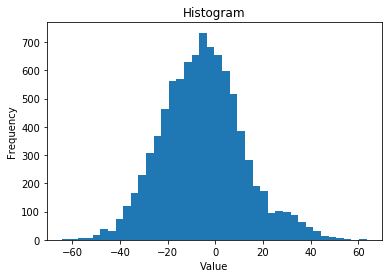

In [28]:
from python_speech_features import mfcc 
from python_speech_features import logfbank
from python_speech_features import base
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
import numpy as np
from sklearn import mixture
import itertools
from scipy import linalg
import matplotlib as mpl

def mfcc_wav(file):
    (rate,sig) = wav.read(file)
    mfcc_feat = mfcc(sig,rate,nfft=512,appendEnergy=True)
    return mfcc_feat

mfcc_feat=mfcc_wav("mundo.wav")
plt.hist(mfcc_feat.T[5], bins=40)
plt.title("Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

In [29]:
WINDOW_SIZE=20
mundo_size=mfcc_feat.shape[0]-WINDOW_SIZE+1
mundo=np.array([mfcc_feat[i:i+WINDOW_SIZE].reshape(1,WINDOW_SIZE*mfcc_feat.shape[1])[0] for i in range(mundo_size)])

In [30]:
mundo.shape

(8999, 260)

In [31]:
mundo_labels=np.array([[1]]*mundo.shape[0])

In [32]:
mundo_labels[0]

array([1])

In [33]:
mundo_labels.shape

(8999, 1)

In [34]:
mfcc_feat=mfcc_wav("homero.wav")

In [35]:
homero_size=mfcc_feat.shape[0]-WINDOW_SIZE+1
homero=np.array([mfcc_feat[i:i+WINDOW_SIZE].reshape(1,WINDOW_SIZE*mfcc_feat.shape[1])[0] for i in range(homero_size)])

In [39]:
homero.shape

(1835, 260)

In [36]:
homero[0].shape

(260,)

In [37]:
homero_labels=np.array([[0]]*homero.shape[0])

In [38]:
homero_labels.shape

(1835, 1)

In [40]:
mundo_labels.shape

(8999, 1)

In [41]:
train_labels=np.vstack([homero_labels,mundo_labels])

In [42]:
train_set=np.vstack([homero,mundo])

In [43]:
train_set.shape

(10834, 260)

In [44]:
train_labels.shape

(10834, 1)

In [45]:
mfcc_feat=mfcc_wav("mundo_test_1.wav")
mundo_size=mfcc_feat.shape[0]-WINDOW_SIZE+1
mundo=np.array([mfcc_feat[i:i+WINDOW_SIZE].reshape(1,WINDOW_SIZE*mfcc_feat.shape[1])[0] for i in range(mundo_size)])
mundo_labels=np.array([[1]]*mundo.shape[0])
mfcc_feat=mfcc_wav("homero_test.wav")
homero_size=mfcc_feat.shape[0]-WINDOW_SIZE+1
homero=np.array([mfcc_feat[i:i+WINDOW_SIZE].reshape(1,WINDOW_SIZE*mfcc_feat.shape[1])[0] for i in range(homero_size)])
homero_labels=np.array([[0]]*homero.shape[0])
test_labels=np.vstack([homero_labels,mundo_labels])
test_set=np.vstack([homero,mundo])

mfcc_feat=mfcc_wav("mundo_test_2.wav")
mundo_size=mfcc_feat.shape[0]-WINDOW_SIZE+1
mundo=np.array([mfcc_feat[i:i+WINDOW_SIZE].reshape(1,WINDOW_SIZE*mfcc_feat.shape[1])[0] for i in range(mundo_size)])
mundo_labels=np.array([[1]]*mundo.shape[0])
mfcc_feat=mfcc_wav("homero_test_2.wav")
homero_size=mfcc_feat.shape[0]-WINDOW_SIZE+1
homero=np.array([mfcc_feat[i:i+WINDOW_SIZE].reshape(1,WINDOW_SIZE*mfcc_feat.shape[1])[0] for i in range(homero_size)])
homero_labels=np.array([[0]]*homero.shape[0])
test2_labels=np.vstack([homero_labels,mundo_labels])
test2_set=np.vstack([homero,mundo])

In [58]:
import keras
from keras.models import Sequential
from keras.layers import Dense
batch_size = 128
epochs = 12
model=Sequential()
model.add(Dense(30,input_shape=(260,)))
model.add(Dense(1,activation="sigmoid"))
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 30)                7830      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 31        
Total params: 7,861
Trainable params: 7,861
Non-trainable params: 0
_________________________________________________________________


In [59]:
model.fit(x=train_set,y=train_labels,validation_data=[test_set,test_labels],epochs=1)

Train on 10834 samples, validate on 366 samples
Epoch 1/1
10834/10834 [==============================] - 1s 59us/step - loss: 1.2869 - acc: 0.9005 - val_loss: 1.7247 - val_acc: 0.8607
